<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

#### Project Overview and Import Modules:

Use the Keras API with TensorFlow as its backend to build and train a bidirectional LSTM neural network model to recognize named entities in text data. Named entity recognition models can be used to identify mentions of people, locations, organizations, etc.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.0
GPU detected: []


#### Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

#### Retrieve Sentences and Corresponsing Tags

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

#### Define Mappings between Sentences and Tags

In [11]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [37]:
#word2idx
tag2idx

{'I-eve': 0,
 'I-geo': 1,
 'I-org': 2,
 'I-art': 3,
 'I-tim': 4,
 'B-tim': 5,
 'I-nat': 6,
 'B-eve': 7,
 'I-gpe': 8,
 'O': 9,
 'B-per': 10,
 'I-per': 11,
 'B-art': 12,
 'B-org': 13,
 'B-gpe': 14,
 'B-geo': 15,
 'B-nat': 16}

#### Padding Input Sentences and Creating Train/Test Splits

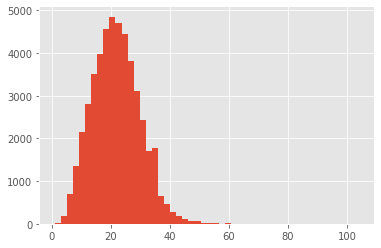

In [38]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
#X = [[w for w in s] for s in sentences]
print(X[:1])
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
print('--'*50)
print(X[:1])
print('--'*50)
#print(X)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
print(y[:1])
print('--'*50)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print(y[:1])

[[1856, 27732, 2017, 25976, 30039, 17570, 15329, 28552, 32093, 973, 22822, 7661, 19586, 31461, 25881, 973, 6893, 27732, 4469, 20115, 125, 22937, 17232, 17925]]
----------------------------------------------------------------------------------------------------
[[ 1856 27732  2017 25976 30039 17570 15329 28552 32093   973 22822  7661
  19586 31461 25881   973  6893 27732  4469 20115   125 22937 17232 17925
  35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
  35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
  35178 35178]]
----------------------------------------------------------------------------------------------------
[[9, 9, 9, 9, 9, 9, 15, 9, 9, 9, 9, 9, 15, 9, 9, 9, 9, 9, 14, 9, 9, 9, 9, 9]]
----------------------------------------------------------------------------------------------------
[[ 9  9  9  9  9  9 15  9  9  9  9  9 15  9  9  9  9  9 14  9  9  9  9  9
   9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Build and Compile a Bidirectional LSTM Model

In [41]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [42]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [43]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#### Train the Model

In [53]:
pip install livelossplot==0.5.2

  Attempting uninstall: livelossplot
    Found existing installation: livelossplot 0.1.2
    Uninstalling livelossplot-0.1.2:
      Successfully uninstalled livelossplot-0.1.2
Note: you may need to restart the kernel to use updated packages.


In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.inputs.tf_keras import PlotLossesCallback

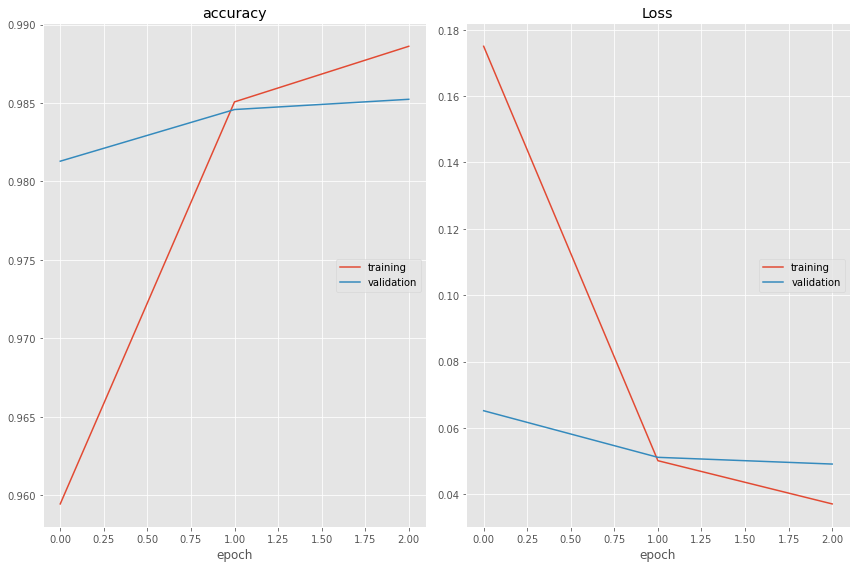

accuracy
	training         	 (min:    0.959, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.037, max:    0.175, cur:    0.037)
	validation       	 (min:    0.049, max:    0.065, cur:    0.049)

Epoch 3: val_loss improved from 0.05114 to 0.04912, saving model to model_weights.h5
1199/1199 [==============================] - 105s 87ms/step - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.0491 - val_accuracy: 0.9852
CPU times: user 30min 20s, sys: 1min 47s, total: 32min 8s
Wall time: 6min 26s


In [58]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

#### Evaluate Named Entity Recognition Model

In [59]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 4s 14ms/step - loss: 0.0491 - accuracy: 0.9852


[0.04911653324961662, 0.985237717628479]

In [60]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 525ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau          O	O
Macau        